In [ ]:
# Class 6 - Learning à la ‘Guess who?’

<img src="https://cf.geekdo-images.com/imagepage/img/1WAsoas3Mh5qjll0m75I_dTn3io=/fit-in/900x600/filters:no_upscale()/pic335812.jpg" width="300"/>

How do we learn the figure of the other player? In fact, this is done by using a hierarchy of if/else questions leading to a decision.
<img src="https://lh4.googleusercontent.com/v9UQUwaQTAXVH90b-Ugyw2_61_uErfYvTBtG-RNRNB_eHUFq9AmAN_2IOdfOETnbXImnQVN-wPC7_YzDgf7urCeyhyx5UZmuSwV8BVsV8VnHxl1KtgpuxDifJ4pLE23ooYXLlnc"/>

The tree consists of internal nodes and leaves. At each internal node, a TRUE/FALSE question is posed. If a certain sample is answering the question with true, if moves to the left node below, otherwise it moves to the right node below. At a leaf a value/prediction is assigned according to a majority vote of the remaining samples.

Decision trees are quite flexible on the form of input and output. For now, let us consider $\mathcal{X} = ℝ^d$ and $\mathcal{Y}=\{0,1\}$. We will see later that decision trees can be actually also used for regression problems. It actually can also solve problems which are entirely not linear!

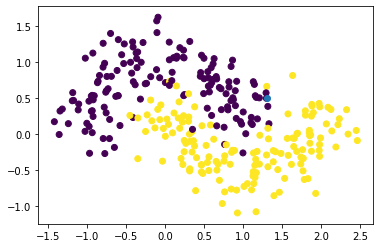

In [1]:
%matplotlib inline
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

x, y = make_moons(300, noise=0.25, random_state=5)

plt.scatter(x[:,0], x[:,1], c=y)
plt.scatter([1.3], [0.5])
plt.show()

How would you learn these data?

#### Advantages
- Simple to understand and to interpret as trees can be visualised.
- Only little data preparation needed.
- Prediction time logarithmic only in the number of samples.
- Can handle numerical and categorical data at the same time.
- Can do multiclass classification

#### Disadvantiges
- Can create overcomplex trees that do not generalize well. (See pruning to overcome this.)
- Small variations in data might result in completely different tree. (See ensemble methods to overcome this.)
- Learning an optimal tree is NP-complete. So we can only use a greedy approach.

## How to learn a decision tree from data

Tree training means split point selection. As learning the whole tree at once is NP-complete, we do this in a greedy way, i.e. we learn the best choice for splitting our data at any specific node. Put differently, we cycle through all possible features and split according to the *best* choice.

### Feature selection

All decisions for splitting will be of the form **feature $\le$ value**.  
*Binary features*: For a binary feature $x^{(j)} ∈ \{0,1\}$, we simply split according to $x^{(j)} = 1$, resp. $x^{(j)} = 0$.  
*Real features*: For real features $x^{(j)} ∈ ℝ$, we usually decide to split using hyperplanes, i.e. according to some rule $x^{(j)} \le c$, resp. $x^{(j)} > c$ for some $c∈ℝ$. Notice that we do not need to consider all values $c∈ℝ$. Instead, we can order the different samples $x_1^{(j)},…,x_n^{(j)}$ according to their value $x_{m_1}^{(j)} \le x_{m_2}^{(j)} \le \dotsb \le x_{m_n}^{(j)}$ and pick only one value for $c$ in each of the intervals $(x_{m_1}^{(j)},x_{m_2}^{(j)}\rbrack, …, (x_{m_{n−1}}^{(j)},x_{m_n}^{(j)}\rbrack$. Hence, we end up with a finite list $(c_{j,1},…,c_{j,n-1})$ of choices for splitting in this case as well, i.e. we recover the binary features case.  
*Multinomial features*: For categorical features with more than two outcomes one should use the so-called one-hot encoding, that means we encode each posssible outcome $\star$ in a new binary feature stating if a sample has $\star$ or not. For example one would encode $\{\text{blue}, \text{yellow}, \text{darkred}\}$ not as $\{0,1,2\}$ but rather as three features $\{(1,0,0), (0,1,0), (0,0,1)\}. Otherwise our linear split might learn a connection between different colors which is not present.

### Choice of gain measures
How do we now evaluate which split is the best choice? This is typically done according to some gain measure. Let us denote
$$\mathbb{P}_S(y=1) = \frac{1}{|S|}\sum_{(x,y)∈S} y$$
and
$$\mathbb{P}_S(y=1|x^{(j)} \le c) = \frac{1}{|S_{j,c}|} \sum_{(x,y)∈S_{j,c}} y \qquad\text{with }S_{j,c} = \{(x,y)∈S | x^{(j)} \le c\}.$$
*Train error*: Denote $C(a) = \min\{a,1−a\}$. The training error before splitting is then given by $C(\mathbb{P}_S(y=1))$. The error after splitting in feature $j$ at value $c$ is the averaged error on both parts, so it is $\mathbb{P}_S(x^{(j)} \le c) * C(\mathbb{P}_S(y=1|x^{(j)}\le c)) + \mathbb{P}_S(x^{(j)}> c) * C(\mathbb{P}_S(y=1|x^{(j)} > c))$. Hence, the gain is given by
$$\text{Gain}(S,j,c) = C(\mathbb{P}_S(y=1)) - \Bigl( \mathbb{P}_S(x^{(j)} \le c) * C(\mathbb{P}_S(y=1|x^{(j)}\le c)) + \mathbb{P}_S(x^{(j)}> c) * C(\mathbb{P}_S(y=1|x^{(j)} > c)) \Bigr).$$
Unfortunately, the function $C$ is not differentiable. Hence, it is common practice to use a differentiable/smooth approximation for it.  
*Information gain*: Use $C(a) = −a\log(a) − (1−a)\log(1−a)$. This error we have already encountered in the logistic regression. Is is the log-likelyhood. Information gain is actually one of the most commonly used gain measures in practice.  
*Gini index*: Use $C(a) = 2a(1−a)$. This gain measure is actually used in more modern algorithms.
They are all smooth upper bounds for the training error.

### Pseudocode

The most popular algorithm to learn a decision tree is the so-called ID3 (Iterative Dichotomiser 3) algorithm and its sucessors. It builds the tree recursively. To start the algorithm, call $\text{ID3}(S,A)$ with $S$ being the train set and $A$ being the set of all possible split points.

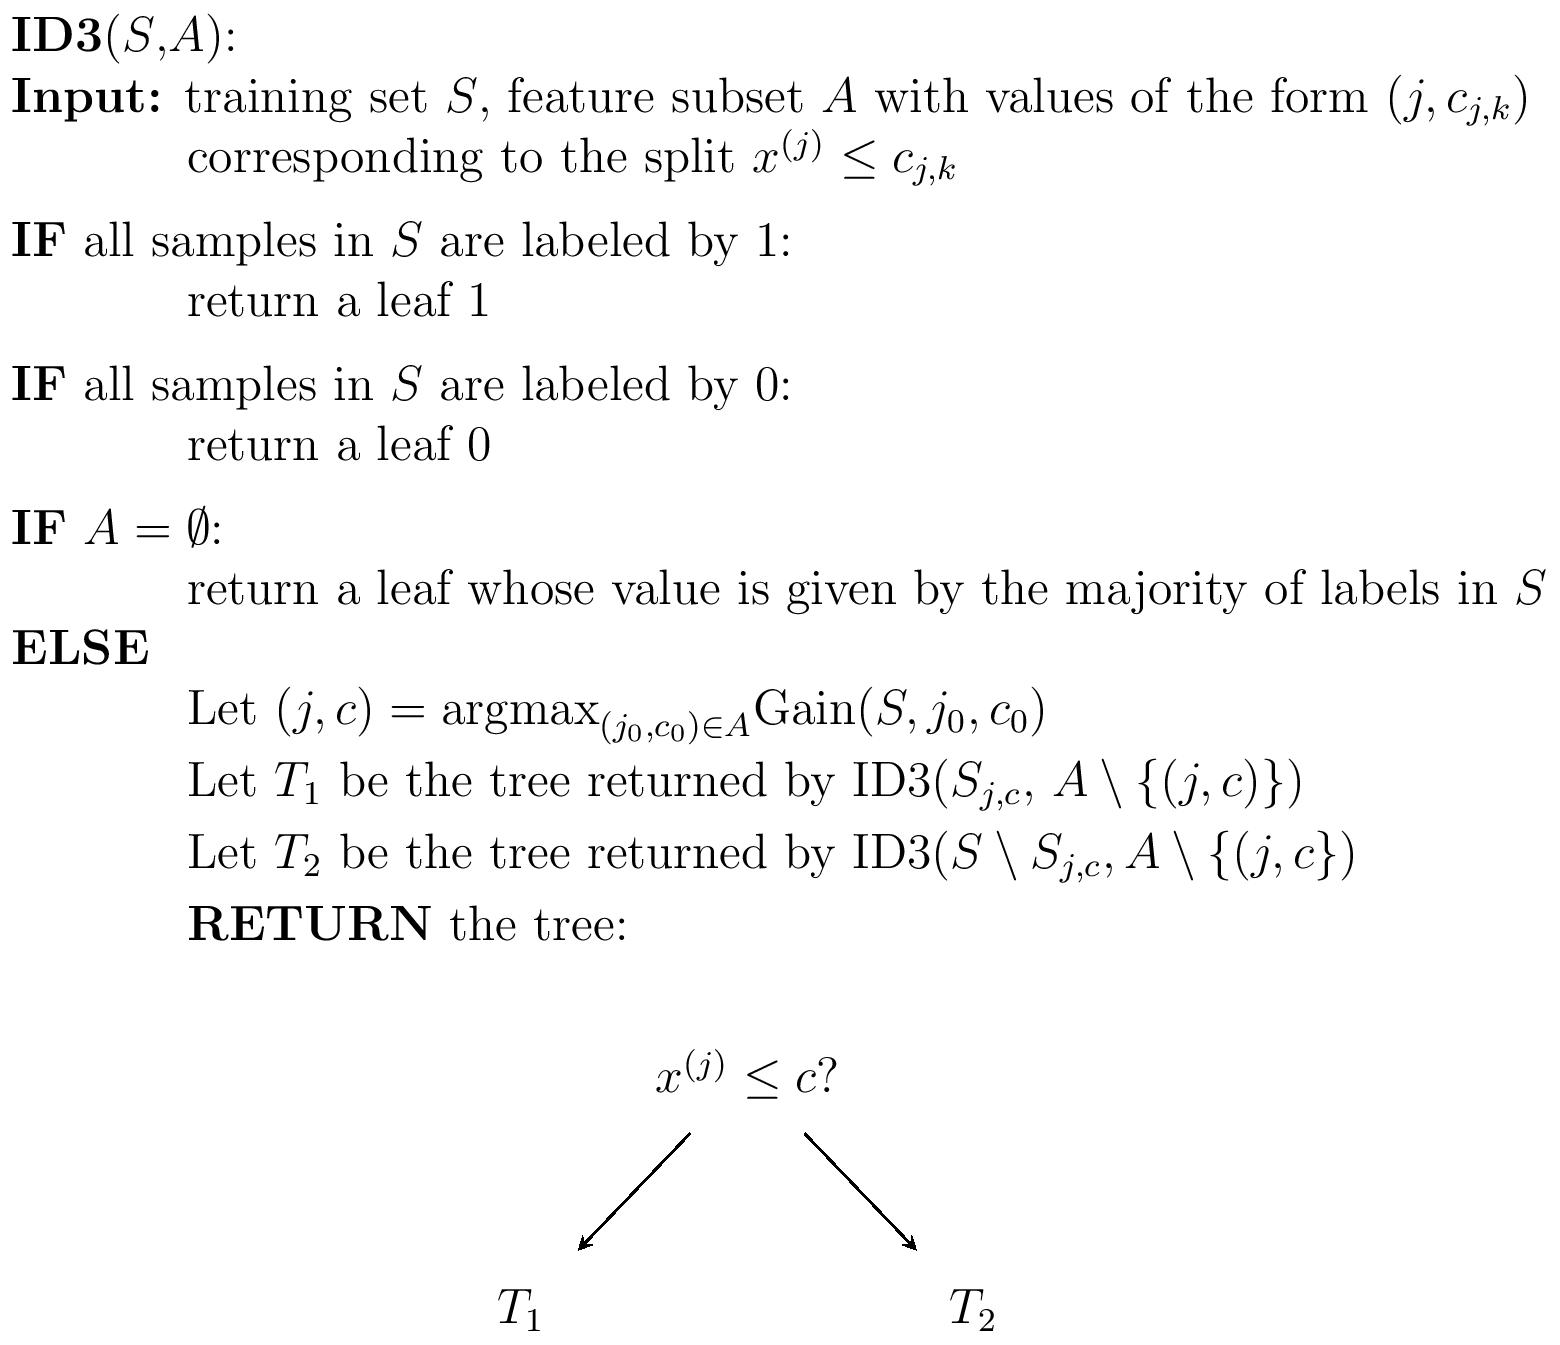

### The algo

Let's prepare the data as usual.

In [2]:
import math


def shuffle(x, y):
    y = y.reshape(-1,1)
    z = np.hstack((x, y))
    np.random.shuffle(z)
    x_new, y_new = np.hsplit(z, [x.shape[1]])
    return x_new, y_new.reshape(-1)

x, y = shuffle(x, y)

def splitting(x, y, test_size=0.2):
    n = x.shape[0]
    train_size = int(n * (1 - test_size))
    return x[:train_size, ], x[train_size:, ], y[:train_size, ], y[train_size:, ]

x_train, x_test, y_train, y_test = splitting(x, y)

Now, we set up the functions to learn the decision tree.

In [3]:
def gain(x, y, j, c):
    def error(x):
        if x==0:
            return 0
        if x==1:
            return 0
        else:
            return -x * math.log(x) - (1 - x) * math.log(1 - x)

    split = x[:, j] <= c
    if all(split):
        return 0
    if all(np.logical_not(split)):
        return 0
    error_old = error(np.mean(y))
    error_new = np.mean(split) * error(np.mean(y[split])) + (1 - np.mean(split)) * error(np.mean(y[np.logical_not(split)]))
    return error_old - error_new


def decision_tree_train(x, y, feature_set):
    if np.mean(y) == 1:  # Check if all examples have same label
        return [1]
    if np.mean(y) == 0:  # Check if all examples have same label
        return [0]
    if not feature_set:  # Check if no feature left to split, return prob.
        return [np.mean(y)]

    # Calculate best index to split
    best_split = []
    best_split_gain = 0
    for new_split in feature_set:  # Find best split point
        new_gain = gain(x, y, *new_split)
        if new_gain > best_split_gain:
            best_split = new_split
            best_split_gain = new_gain
    if best_split_gain == 0:
        return [np.mean(y)]
    split = x[:, best_split[0]] <= best_split[1]

    # Update samples
    x_new_one = x[split, :]
    x_new_two = x[np.logical_not(split), :]
    y_new_one = y[split]
    y_new_two = y[np.logical_not(split)]
    feature_set.remove(best_split)
    return [best_split, best_split_gain, decision_tree_train(x_new_one, y_new_one, feature_set), decision_tree_train(x_new_two, y_new_two, feature_set)]


def all_features(x):
    n, d = x.shape
    feature_set = []
    for j in range(d):
        x_j_sorted = np.sort(x[:, j])
        for i in range(n-1):
            feature_set.append([j, (x_j_sorted[i+1]+x_j_sorted[i])/2])
    return feature_set

Finally, we still need some functions to evaluate our performance.

In [4]:
def decision_tree_predict_prob(x, tree):
    def decision_tree_predict_prob_el(x_i, tree):
        if len(tree) == 1:
            return tree[0]
        else:
            j = tree[0][0]
            c = tree[0][1]
            if x_i[j] <= c:
                return decision_tree_predict_prob_el(x_i, tree[2])
            else:
                return decision_tree_predict_prob_el(x_i, tree[3])
    prediction = np.array([])
    for x_i in x:
        prediction = np.append(prediction, decision_tree_predict_prob_el(x_i, tree))
    return prediction


def decision_tree_predict_label(x, tree):
    return np.rint(decision_tree_predict_prob(x, tree))


def zero_one_loss(y_true, y_pred):
    n = y_true.shape[0]
    return (1/n) * np.sum(y_true != y_pred)


def log_loss(y_true, y_pred):
    n = y_true.shape[0]
    result = np.zeros(n)
    y_zero = y_true == 0
    result[y_zero] = -np.log(1-y_pred[y_zero])
    y_one = y_true == 1
    result[y_one] = -np.log(y_pred[y_one])
    return np.mean(result)

Let's apply the algo to see how we perform.

In [5]:
feature_set = all_features(x_train)
tree = decision_tree_train(x_train, y_train, feature_set)

print(tree)

train_predicted_labels = decision_tree_predict_label(x_train, tree)
train_predicted_prob = decision_tree_predict_prob(x_train, tree)
test_predicted_labels = decision_tree_predict_label(x_test, tree)
test_predicted_prob = decision_tree_predict_prob(x_test, tree)

print('Train 0-1 loss:', zero_one_loss(y_train, train_predicted_labels))
print('Train log-loss:', log_loss(y_train, train_predicted_prob))
print('-----------------------------------------------------------------------')
print('Test 0-1 loss:', zero_one_loss(y_test, test_predicted_labels))
print('Test log-loss:', log_loss(y_test, test_predicted_prob))

[[1, 0.4573877342593413], 0.25847084381129987, [[0, -0.41294677452524053], 0.24317383627676437, [0], [[1, 0.09095434936230411], 0.08955541010287227, [[1, -0.26222975604614096], 0.018180981911690555, [1], [[1, -0.25729468379561415], 0.08224949010953382, [0], [[1, 0.005346233580173989], 0.030989700840503204, [1], [[1, 0.009072742139586717], 0.28683598305616076, [0], [1]]]]], [[0, 0.48396071181154976], 0.16316975037343256, [1], [[0, 1.3566899547339781], 0.5590366723292459, [[0, 0.5841124238990549], 0.15829761474955373, [[0, 0.5397140503741625], 0.6931471805599453, [0], [1]], [0]], [1]]]]], [[0, 1.2973665075726522], 0.06322064552064227, [[1, 0.7341074928948544], 0.038525342277727276, [[0, 0.3000169722374624], 0.06849686419719286, [[0, -0.23597571945056767], 0.259276674564445, [0], [[0, 0.05404777556012788], 0.08878194993480437, [[0, -0.18650109552609437], 0.6365141682948128, [1], [0]], [[1, 0.5561471601998839], 0.5623351446188083, [0], [1]]]], [0]], [0]], [1]]]
Train 0-1 loss: 0.0
Train lo

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


Wow, our algorithm seems to overfit a lot!!! Actually, this is quite clear as we train as long until we really learned all the possible outcomes by heart.

## How to prevent overfitting - pruning

Typically, decision trees tend to overfit. This is due to the fact that we create overly complex trees. Fortunately, there are several ways to prevent them from doing so. Those are called pruning. Usually, one distincts between prepruning and postpruning. The former controls the tree to become not too complex while being built. The later decreases the complexity only after the full tree was built.

Options for prepruning:
- limit maximum tree depth (recall that the tree grows exponentially in its depth)
- set lower bound on increasing gain in one step
- limit minimum leave node size

Options for postpruning:
- cut branches that do not contribute to a good increase in the gain
- cut branches that contain only few samples

In practice prepruning is easier to implement and often sufficient. The hyperparameters can then be estimated using e.g. leave-one-out cross validation.

Let's see how our prepruned algorithm would look like.

In [6]:
def decision_tree_train(x, y, feature_set, max_depth = math.inf):
    if np.mean(y) == 1:  # Check if all examples have same label
        return [1]
    if np.mean(y) == 0:  # Check if all examples have same label
        return [0]
    if not feature_set:  # Check if no feature left to split
        return [np.mean(y)]
    
    # Stop if max_depth reached 0
    if max_depth <= 0:
        return [np.mean(y)]
    else:
        max_depth -= 1

    # Calculate best index to split
    best_split = []
    best_split_gain = 0
    for new_split in feature_set:  # Find best split point
        new_gain = gain(x, y, *new_split)
        if new_gain > best_split_gain:
            best_split = new_split
            best_split_gain = new_gain
    if best_split_gain == 0:
        return [np.mean(y)]
    split = x[:, best_split[0]] <= best_split[1]

    # Update samples
    x_new_one = x[split, :]
    x_new_two = x[np.logical_not(split), :]
    y_new_one = y[split]
    y_new_two = y[np.logical_not(split)]
    feature_set.remove(best_split)
    return [best_split, best_split_gain, decision_tree_train(x_new_one, y_new_one, feature_set, max_depth), decision_tree_train(x_new_two, y_new_two, feature_set, max_depth)]


Let's see how well our pruned decision tree is doing. Recall that we had 300 sample points in total. 80% of them can be used for training. Hence, our decision tree should less deep that $\log_2(240) \approx 8$.

In [7]:
feature_set = all_features(x_train)
tree = decision_tree_train(x_train, y_train, feature_set, max_depth = 7)

print(tree)

train_predicted_labels = decision_tree_predict_label(x_train, tree)
train_predicted_prob = decision_tree_predict_prob(x_train, tree)
test_predicted_labels = decision_tree_predict_label(x_test, tree)
test_predicted_prob = decision_tree_predict_prob(x_test, tree)

print('Train 0-1 loss:', zero_one_loss(y_train, train_predicted_labels))
print('Train log-loss:', log_loss(y_train, train_predicted_prob))
print('-----------------------------------------------------------------------')
print('Test 0-1 loss:', zero_one_loss(y_test, test_predicted_labels))
print('Test log-loss:', log_loss(y_test, test_predicted_prob))

[[1, 0.4573877342593413], 0.25847084381129987, [[0, -0.41294677452524053], 0.24317383627676437, [0], [[1, 0.09095434936230411], 0.08955541010287227, [[1, -0.26222975604614096], 0.018180981911690555, [1], [[1, -0.25729468379561415], 0.08224949010953382, [0], [[1, 0.005346233580173989], 0.030989700840503204, [1], [[1, 0.009072742139586717], 0.28683598305616076, [0], [1]]]]], [[0, 0.48396071181154976], 0.16316975037343256, [1], [[0, 1.3566899547339781], 0.5590366723292459, [[0, 0.5841124238990549], 0.15829761474955373, [[0, 0.5397140503741625], 0.6931471805599453, [0], [1]], [0]], [1]]]]], [[0, 1.2973665075726522], 0.06322064552064227, [[1, 0.7341074928948544], 0.038525342277727276, [[0, 0.3000169722374624], 0.06849686419719286, [[0, -0.23597571945056767], 0.259276674564445, [0], [[0, 0.05404777556012788], 0.08878194993480437, [[0, -0.18650109552609437], 0.6365141682948128, [1], [0]], [[1, 0.5561471601998839], 0.5623351446188083, [0], [1]]]], [0]], [0]], [1]]]
Train 0-1 loss: 0.0
Train lo

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


## The algorithm using scikit-learn

Scikit-learn only works with real features and splits according to feature <= value. In case of categorial data one can use sklearn.preprocessing.LabelEncoder to transform them into real features. Moreover, the algorithm in scikit-learn can also be run on multiclass classification.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection


# x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, shuffle=TRUE, test_size=0.2)

clf = DecisionTreeClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, random_state=0).fit(x_train, y_train)

train_predicted_labels = clf.predict(x_train)
train_predicted_prob = clf.predict_proba(x_train)[:,1] # predict_proba provides probability for each class
test_predicted_labels = clf.predict(x_test)
test_predicted_prob = clf.predict_proba(x_test)[:,1]

print('Train 0-1 loss:', zero_one_loss(y_train, train_predicted_labels))
print('Train log-loss:', log_loss(y_train, train_predicted_prob))
print('-----------------------------------------------------------------------')
print('Test 0-1 loss:', zero_one_loss(y_test, test_predicted_labels))
print('Test log-loss:', log_loss(y_test, test_predicted_prob))

Train 0-1 loss: 0.075
Train log-loss: 0.1540131510181665
-----------------------------------------------------------------------
Test 0-1 loss: 0.16666666666666666
Test log-loss: inf


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


Scikit-learn provides two easy way to understand how the learned tree looks like. One is using the pyplot library while the other uses the graphviz format. In case graphviz is not part of your python installation already, run

    pip3 install graphviz

or

    conda install python-graphviz

in a terminal. For example you can use the tree to observe where the majority of samples moves, what splits are performed and even if the tree tends to overfit or not.

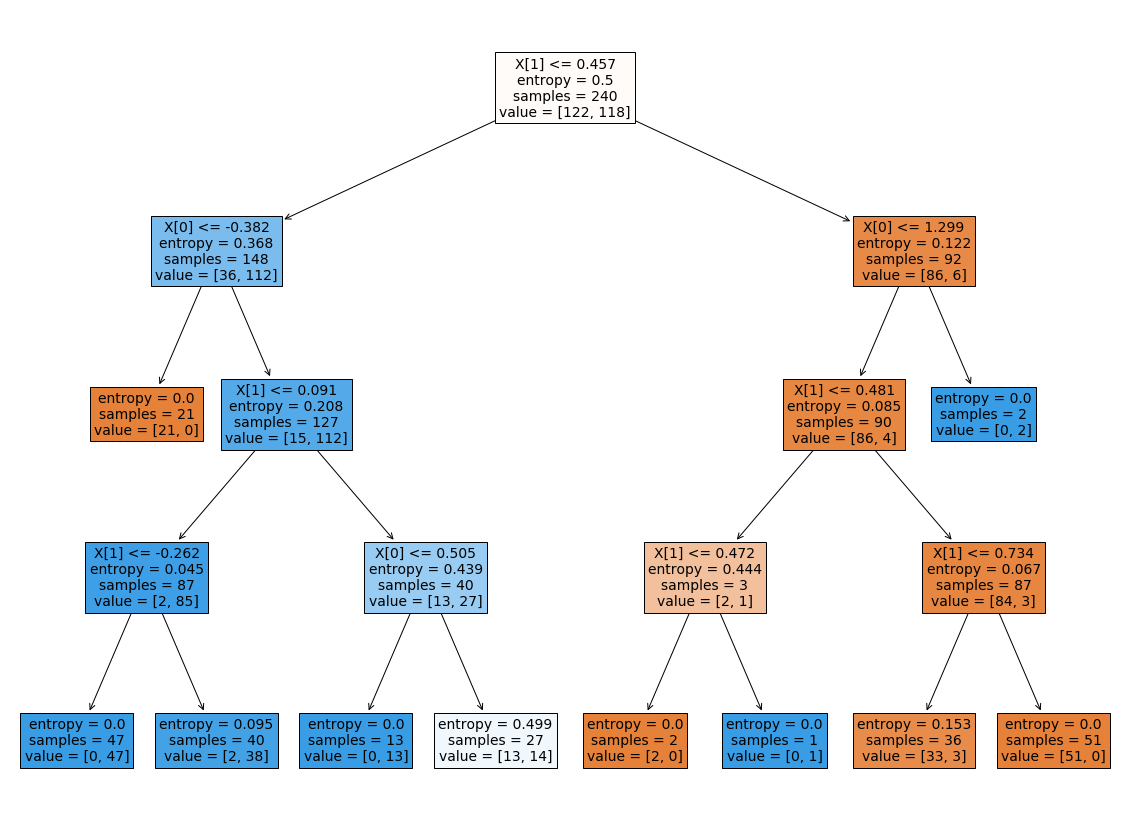

In [9]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,15))
plot_tree(clf, filled=True)
plt.show()

In [10]:
from sklearn.tree import export_graphviz
import graphviz

dot_data_tree = export_graphviz(clf, out_file=None, class_names=["yellow", "purple"], feature_names=["x1", "x2"], filled=True)
graph = graphviz.Source(dot_data_tree)
graph.render("Decision tree")

ModuleNotFoundError: No module named 'graphviz'

## Some practical tips

- Be careful with overfitting, especially if the number of features is large.
- Visualize your tree for e.g. max_depth=3 to get a feeling for what is happening. Then increase max_depth slowly. Remember that the number of samples needed grows exponentially in the maximum depth of the tree.
- Balance the dataset before training to prevent the tree from being biased towards the classes that are dominant. This can be done e.g. by using bootstrap.

## Exercises

1. Play around with the pruning techniques to observe overfitting and underfitting of the tree.  maxstep
2. Implement further prepruning and postpruning techniques to our algorithm.
3. Apply the decision tree to the titanic dataset. Is it performing better or worse than the logistic regression? Remember to use validation and test sets to get a proper estimate of your performance.
4. Implement leave-one-out cross validation for decision trees. Compare your performance to classical validation.